In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.lax as lax
from jax import random
from jax.random import PRNGKey, normal
import matplotlib.pyplot as plt
from functools import partial
from jax import vmap
from jax.tree import map
import time
import optax

In [3]:
def initial_mask(A):
    A += jnp.transpose(A, (1, 0))
    A += A[::-1, :]
    A += A[:, ::-1] 
    A /= 8
    return A[:-1, :-1]

def backward_propagate_grads(B):
    # Step 1: Pad the 4x4 gradients to match the 5x5 matrix by adding zeros
    A = jnp.pad(B, ((0, 1), (0, 1)), mode='constant')

    # Step 2: Reverse the rolling (adjust this step if rolling was applied in your forward function)

    # Step 3: Undo the averaging by distributing the gradient contributions
    # Since the averaging involved adding the matrix to itself in various transformations,
    # we need to create a full 5x5 matrix that sums all these transformations' contributions
    A+= jnp.transpose(A, (1, 0))
    A+= A[::-1, :]
    A+= A[:, ::-1]
    A = A/8
    return A


In [4]:
A = random.normal(PRNGKey(4), (4, 4))
B = random.normal(PRNGKey(5), (5, 5))
print(initial_mask(B, 4))
print(jnp.sum(A.reshape(-1, 1, 1) * (jax.jacfwd(initial_mask)(B, 4).reshape(16, 5, 5)), axis = 0))
print(backward_propagate_grads(A, 4))

TypeError: initial_mask() takes 1 positional argument but 2 were given

In [7]:
@jax.jit
def phi4_action(phi, m2, lam):
    """Compute the Euclidean action for the scalar phi^4 theory.

    The Lagrangian density is kin(phi) + m2 * phi + l * phi^4

    Args:
        phi: Single field configuration of shape L^d.
        m2: Mass squared term (can be negative).
        lam: Coupling constant for phi^4 term.

    Returns:
        Scalar, the action of the field configuration..
    """

    a = jnp.sum(m2 * phi ** 2)
    if lam is not None:
        a += jnp.sum(lam * phi ** 4)
    # Kinetic term
    a += jnp.sum(jnp.array([phi*(phi - jnp.roll(phi, 1, d)/2 - jnp.roll(phi, -1, d)/2)  for d in range(len(phi.shape))]))

    return a

@jax.jit
def diff_phi4_action(phi, m2, lam):
    a = 2 * m2 * phi
    if lam is not None:
        a += 4 * lam * phi ** 3
    for d in range(len(phi.shape)):
        a += 2*phi - jnp.roll(phi, 1, d) - jnp.roll(phi, -1, d)
    return a


In [8]:

print(jax.grad(phi4_action)(A, 1, 1))
print(diff_phi4_action(A, 1, 1))

[[  0.4749732 -53.08032   -29.23644    -2.2732904]
 [-15.48554     3.8560271   1.1160575  14.21506  ]
 [  3.562736    2.4999046   0.4486555  -1.6691296]
 [-14.193397    8.0586815  -1.3325311   1.123336 ]]
[[  0.4749732 -53.08032   -29.23644    -2.2732904]
 [-15.48554     3.8560271   1.1160575  14.215059 ]
 [  3.5627356   2.4999046   0.4486555  -1.6691295]
 [-14.1933975   8.0586815  -1.332531    1.123336 ]]


In [9]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2 * jax.scipy.special.logsumexp(logw, axis=0) - jax.scipy.special.logsumexp(2 * logw, axis=0)
    ess_per_cfg = jnp.exp(log_ess) / len(logw)
    return ess_per_cfg

def normal_pdf(x):
    """Calculate the PDF of a standard normal distribution."""
    return (1 / jnp.sqrt(2 * jnp.pi)) * jnp.exp(-0.5 * x ** 2)

def get_batch(num_samples, L, seed):
    #   Generate a batch of samples from a standard normal distribution.
    key = PRNGKey(seed)
    x = normal(key, (num_samples, L, L))
    logp_x= jnp.sum(jnp.log(normal_pdf(x)), axis=(1, 2)) # log probability of each sample
    
    return(x, logp_x, -x)



In [11]:
#@partial(jax.custom_vjp, nondiff_argnums=(0, 1))
    
def W_t(a, t):
    b = a.shape[0]//2
    return a[0]+jnp.sum(a[1:b+1]*(jnp.sin((jnp.arange(b)+1)*t)).reshape(-1, 1, 1, 1), axis = 0) + jnp.sum(a[b+1:]*(jnp.cos((jnp.arange(b)+1)*t)).reshape(-1, 1, 1, 1), axis = 0)
def omega_t(a, t):
    b = a.shape[0]//2
    return a[0]+jnp.sum(a[1:b+1]*(jnp.sin((jnp.arange(b)+1)*t)).reshape(-1, 1), axis = 0) + jnp.sum(a[b+1:]*(jnp.cos((jnp.arange(b)+1)*t)).reshape(-1, 1), axis = 0)
def mul_const_tree(tree, const):
    """Multiplies every element in the pytree by a constant."""
    return jax.tree.map(lambda x: x * const, tree)

def add_trees(*trees):
    """Adds multiple pytrees together."""
    return jax.tree.map(lambda *xs: sum(xs), *trees)
    
@partial(jax.jit, static_argnums=(-3, -2, -1))
def rk4_odeint (input_, W_a, omega_a, t0, tf, dt):
    def func_(input_, t,  W_a, omega_a):
        x, logp_x, d_logp_x, diff_xf_W, diff_xf_omega = input_
        W = W_t(W_a, t)
        omega = omega_t(omega_a, t)
        t_k = W_a.shape[0]//2
        
        a_w = jnp.concatenate((jnp.array([1., ]), jnp.sin((jnp.arange(t_k) + 1) * t), jnp.cos((jnp.arange(t_k) + 1) * t)), axis=0)
        a_omega = jnp.concatenate((jnp.array([1., ]), jnp.sin((jnp.arange(t_k) + 1) * t), jnp.cos((jnp.arange(t_k) + 1) * t)), axis=0)
        return (jnp.sum(jnp.fft.ifft2(jnp.fft.fft2(W)*jnp.fft.fft2(jnp.sin(omega.reshape(-1, 1, 1) * x))).real, axis = 0), 
                jnp.sum(W[:,0,0].reshape(-1, 1, 1)*(omega.reshape(-1, 1, 1)*jnp.cos(omega.reshape(-1, 1, 1)*x))),
                -jnp.sum(omega.reshape(-1, 1, 1)*jnp.cos(omega.reshape(-1, 1, 1)*x)*jnp.fft.ifft2(jnp.flip(jnp.roll(jnp.fft.fft2(W), (-1, -1), (-1, -2)), (-1, -2))*jnp.fft.fft2(d_logp_x)).real, axis = 0)+jnp.sum(W[:,0,0].reshape(-1, 1, 1)*((omega**2).reshape(-1, 1, 1)*jnp.sin(omega.reshape(-1, 1, 1)*x)), axis = 0),
                a_w.reshape(-1, 1, 1, 1)*jnp.sin(omega.reshape(-1, 1, 1)*x),
                jnp.fft.ifft2(jnp.fft.fft2(W)*jnp.fft.fft2(a_omega.reshape(-1, 1, 1, 1)*(x*jnp.cos(omega.reshape(-1, 1, 1)*x)))).real)
    

    """Integrate a system of ODEs using the 4th order Runge-Kutta method."""
    def step_func(cur_y, cur_t, dt):
        """Take one step of RK4."""
        k1 = func(cur_y, cur_t, W_a, omega_a)
        k2 = func(add_trees(cur_y, mul_const_tree(k1, dt * 0.4)), cur_t + dt * 0.4, W_a, omega_a)
        k3 = func(add_trees(cur_y, mul_const_tree(k1, dt * 0.29697761), mul_const_tree(k2, dt * 0.15875964)), cur_t + dt * 0.45573725, W_a, omega_a)
        k4 = func(add_trees(cur_y, mul_const_tree(k1, dt * 0.21810040), mul_const_tree(k2, -dt * 3.05096516), mul_const_tree(k3, dt * 3.83286476)), cur_t + dt, W_a, omega_a)

        final_step = add_trees(
            mul_const_tree(k1, dt * 0.17476028),
            mul_const_tree(k2, -dt * 0.55148066),
            mul_const_tree(k3, dt * 1.20553560),
            mul_const_tree(k4, dt * 0.17118478)
        )
        return final_step

    def body_fun(y, t, dt):
        """Take one step of RK4."""
        dy = step_func(y, t, dt)
        return add_trees(y, dy), None
    
    func = vmap(func_, in_axes=(0, None, None, None))
    t = jnp.arange(t0, tf, dt)
    y1, t_dummy = jax.lax.scan(partial(body_fun, dt = dt), input_, t)
    return y1

@partial(jax.jit, static_argnums=(1, 2, 3))
def loss(params, t0, tf, dt, seed):
    W_a0, omega_a = params
    W_a = jnp.transpose(vmap(vmap(initial_mask, (0, )), (1, ))(W_a0), (1, 0, 2, 3))
    x0, logp_x0, dlogp_x0 = get_batch(num_samples, L, seed)
    diff_xf_W_t0 = jnp.zeros_like(jnp.repeat(W_a[None, :], num_samples, axis = 0))
    diff_xf_omega_t0 = jnp.zeros_like(jnp.repeat(W_a[None, :], num_samples, axis = 0))
    xf, logp_prob, diff_logp_x, int_diff_xf_W, int_diff_xf_omega  = rk4_odeint((x0, jnp.zeros(x0.shape[0]), dlogp_x0, diff_xf_W_t0, diff_xf_omega_t0), W_a, omega_a, t0, tf, dt)
    logp_xf = logp_x0 - logp_prob
    logp = -batch_phi4(xf)
    logp_x = logp_xf-logp
    return logp_x.mean(0)

In [16]:
L = 4
lr0 = 0.002
lr_schedule = optax.cosine_decay_schedule(
    init_value = lr0,
    decay_steps = 10000,
    alpha = 1e-4
)
seed = 0 
train_steps = 500
num_samples = 128
f = 9
metro_samples = 1000
t0, tf, dt = 0., 1., 0.02
m2 = -1
lam = 1
t_kernel = 15
W_a0 = jnp.zeros((t_kernel, f, L+1, L+1))
omega_a = jnp.concatenate(((jnp.arange(f)+0.5)[None, :], jnp.zeros((t_kernel-1, f))), axis = 0) 
solver = optimizer = optax.chain(
    optax.scale_by_adam(),  # Use Adam updates to scale the gradients
    optax.scale_by_schedule(lr_schedule),  # Apply the learning rate schedule
    optax.scale(-1)  # Adam is a minimization algorithm, so we negate the gradients
)
params = (W_a0, omega_a)
opt_state = solver.init(params)
batch_phi4 = jax.jit(vmap(partial(phi4_action, m2 = m2, lam = lam), in_axes=(0, )))
batch_diff_phi4 = jax.jit(vmap(partial(diff_phi4_action, m2 = m2, lam = lam), in_axes=(0, )))
method = "pat"
for i in range (train_steps):
    t0_ = time.time()
    if method == "path":
        W_a = jnp.transpose(vmap(vmap(initial_mask, (0,)), (1,))(W_a0), (1, 0, 2, 3))
        x0, logp_x0, dlogp_x0 = get_batch(num_samples, L, seed)
        diff_xf_W_t0 = jnp.zeros_like(jnp.repeat(W_a[None, :], num_samples, axis = 0))
        diff_xf_omega_t0 = jnp.zeros_like(jnp.repeat(W_a[None, :], num_samples, axis = 0))
        xf, logp_prob, diff_logp_x, int_diff_xf_W, int_diff_xf_omega  = rk4_odeint((x0, jnp.zeros(num_samples), dlogp_x0, diff_xf_W_t0, diff_xf_omega_t0), W_a, omega_a, t0, tf, dt)
        diff_logp_x += batch_diff_phi4(xf)
        grad_w = jnp.mean(jnp.fft.ifft2(jnp.flip(jnp.roll(jnp.fft.fft2(int_diff_xf_W), (-1, -1), axis=(-2, -1)), (-2, -1)) * jnp.fft.fft2(diff_logp_x)[:, None, None]).real, axis = 0)
        grad_wa0 = jnp.transpose(vmap(vmap(backward_propagate_grads, (0, )), (1, ))(grad_w), (1, 0, 2, 3))
        grad_omega = jnp.mean(jnp.sum(diff_logp_x[:, None, None]*int_diff_xf_omega, axis = (-2, -1)), axis = 0)
        logp_xf = logp_x0 - logp_prob
        logp = -batch_phi4(xf)
        logp_x = logp_xf-logp
        loss = logp_x.mean(0)
        
        #print("W", W.shape, "omega", omega.shape)
        #print("grad_w", grad_w.shape, "grad_omega", grad_omega.shape)
        updates, opt_state = solver.update((grad_wa0, grad_omega), opt_state, params)
        params = optax.apply_updates(params, updates)
        W_a0, omega_a = params
    else:
        Loss = loss(params, t0, tf, dt, seed)
        grad = jax.grad(loss)((W_a0, omega_a), t0, tf, dt, seed)
        updates, opt_state = solver.update(params, opt_state, params)
        params = optax.apply_updates(params, updates)
        W_a0, omega_a = params
    if i % 10 == 0:
        print("itert: ", time.time() - t0_)
        print('Iter: {}, loss: {:.4f}\n'.format(i, Loss.item()))
        #print("grad_w", grad_w)
        #print("grad_omega", grad_omega)
    seed += 1
    #print(jnp.linalg.norm(W-W_a), jnp.linalg.norm(omega-omega_a))

itert:  2.238956928253174
Iter: 0, loss: 37.7745


KeyboardInterrupt: 

In [143]:
jnp.arange(0, 1, 0.02)

Array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
       0.09999999, 0.12      , 0.14      , 0.16      , 0.17999999,
       0.19999999, 0.22      , 0.24      , 0.26      , 0.28      ,
       0.29999998, 0.32      , 0.34      , 0.35999998, 0.38      ,
       0.39999998, 0.42      , 0.44      , 0.45999998, 0.48      ,
       0.5       , 0.52      , 0.53999996, 0.56      , 0.58      ,
       0.59999996, 0.62      , 0.64      , 0.65999997, 0.68      ,
       0.7       , 0.71999997, 0.74      , 0.76      , 0.78      ,
       0.79999995, 0.82      , 0.84      , 0.85999995, 0.88      ,
       0.9       , 0.91999996, 0.94      , 0.96      , 0.97999996],      dtype=float32)

In [439]:
jnp.concatenate((jnp.array([1,]), jnp.sin(jnp.arange(3)*0.5)), axis = 0)

Array([1.        , 0.        , 0.47942555, 0.84147096],      dtype=float32, weak_type=True)

In [107]:
a = jnp.arange(15)
b = random.normal(PRNGKey(0), (10, 10))
print(b[None].shape)
(a @ b[None]).shape

(1, 10, 10)


TypeError: dot_general requires contracting dimensions to have the same shape, got (15,) and (10,).

In [162]:
import jax.numpy as jnp
import jax

# Define a multidimensional nested pytree
pytree = {
    'first': jnp.array([[1, 2], [3, 4]]),
    'second': (jnp.array([5, 6]), jnp.array([7, 8])),
    'third': {'a': jnp.array([9, 10]), 'b': jnp.array([11, 12])}
}

# Constant to multiply with
constant = 3

# Function to multiply an array by a constant
def multiply_by_constant(array):
    return constant * array

# Multiply every element in the pytree by the constant
result = jax.tree_map(multiply_by_constant, pytree)

print(result)


{'first': Array([[ 3,  6],
       [ 9, 12]], dtype=int32), 'second': (Array([15, 18], dtype=int32), Array([21, 24], dtype=int32)), 'third': {'a': Array([27, 30], dtype=int32), 'b': Array([33, 36], dtype=int32)}}


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6416\3538021090.py:19: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  result = jax.tree_map(multiply_by_constant, pytree)


In [15]:

def serial_sample_generator(key, batch_size, N_sample, L, func):
    config, logq, logp = None, None, None
    for i in range(N_sample): 
        batch_i = i % batch_size
        if batch_i == 0:
            key, subkey = random.split(key)
            x, logp_0 = get_batch(subkey, batch_size, L)
            config, log_prob = func(x)

            logq = logp_0 - log_prob
            logp = -phi4_action(config)
                
        yield config[batch_i], logq[batch_i], logp[batch_i]

def make_mcmc_ensemble(seed, batch_size, N_samples, L, func):
    history = {
        'x': [],
        'logq': [],
        'logp': [],
        'accepted': []
    }
    key = PRNGKey(seed)
    sample_gen = serial_sample_generator(key, batch_size, N_samples, L, func)
    
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # Always accept the first proposal; Markov chain must start somewhere
            accepted = True
        else:
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = jnp.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = jnp.minimum(1, p_accept)

            key, subkey = random.split(key)
            draw = random.uniform(subkey)  # ~ [0, 1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq

        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
        
    return history

history = make_mcmc_ensemble(seed, batch_size, N_samples, L, func, action)
print(history)


NameError: name 'batch_size' is not defined

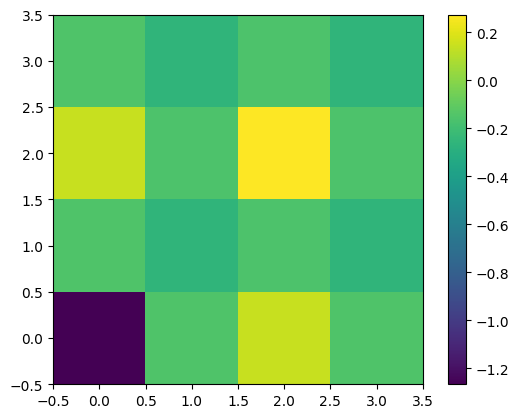

In [71]:
plt.imshow(jnp.roll(C, (2, 2), axis = (0, 1)), cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

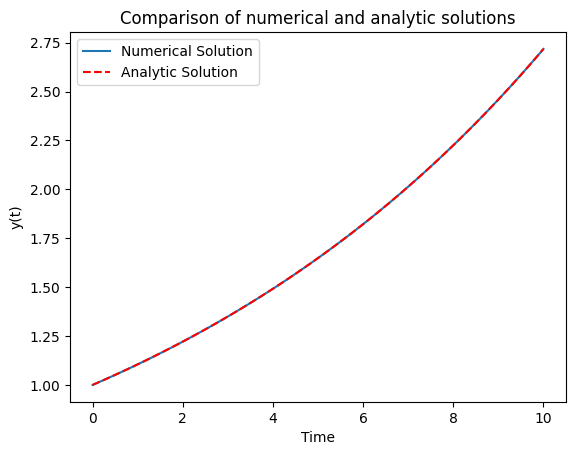

In [132]:
a = random.normal(PRNGKey(0), (5, 5))
b = random.normal(PRNGKey(2), (5, 5))
x = random.normal(PRNGKey(1), (5, 5))

In [133]:
A = jnp.zeros((5, 5, 5, 5))
#B = jnp.diag(b)
for i in range (5):
    for j in range(5):
        A = A.at[:, :, i, j].set(jnp.roll(a, (i, j), (0, 1)))

In [134]:
print(A.reshape(25, -1) @ x.reshape(-1))
print(x.reshape(-1) @ A.reshape(25, -1))

[  4.9020205   2.2453187   6.0527763  -6.7956133  -1.1322783   3.88151
   5.6786556  -5.1068444   5.1702957   2.1860113  10.11021     5.206453
   2.675201    9.035416  -13.685463  -12.599644    0.9317868   0.8740876
   3.25546     4.6386976   2.0873203   2.5537443   3.6725028   1.1157026
 -17.308754 ]
[-10.312873     1.3553374    8.305039     2.1375406    0.41786185
   5.031165     4.115156    -6.0894876   -4.930898    -8.026865
   5.453595   -10.100704     7.485309     6.9605904   -6.8144307
  -2.082107     1.4352393    4.045188     2.203241     5.9556894
   2.7917554   -0.61893487   1.5616025   18.664637    -9.298078  ]


In [139]:
jnp.fft.ifft2(jnp.fft.fft2(a)*jnp.fft.fft2(x))

Array([[  4.9020205 +0.j,   2.2453184 +0.j,   6.0527763 +0.j,
         -6.7956142 +0.j,  -1.1322784 +0.j],
       [  3.8815095 +0.j,   5.678655  +0.j,  -5.1068444 +0.j,
          5.1702957 +0.j,   2.1860118 +0.j],
       [ 10.11021   +0.j,   5.2064524 +0.j,   2.6752026 +0.j,
          9.035415  +0.j, -13.685467  +0.j],
       [-12.599644  +0.j,   0.9317863 +0.j,   0.87408686+0.j,
          3.2554598 +0.j,   4.638699  +0.j],
       [  2.087321  +0.j,   2.5537457 +0.j,   3.672504  +0.j,
          1.1157026 +0.j, -17.308756  +0.j]], dtype=complex64)

In [137]:
jnp.fft.ifft2(jnp.fft.fft2(jnp.flip(jnp.roll(a, (-1, -1), (0, 1)), (0, 1)))*jnp.fft.fft2(x))

Array([[-10.312874  +0.j,   1.3553377 +0.j,   8.30504   +0.j,
          2.1375406 +0.j,   0.41786146+0.j],
       [  5.031166  +0.j,   4.1151576 +0.j,  -6.089489  +0.j,
         -4.9308968 +0.j,  -8.026866  +0.j],
       [  5.4535966 +0.j, -10.100706  +0.j,   7.4853106 +0.j,
          6.9605904 +0.j,  -6.814432  +0.j],
       [ -2.082109  +0.j,   1.4352422 +0.j,   4.045188  +0.j,
          2.2032394 +0.j,   5.9556904 +0.j],
       [  2.7917566 +0.j,  -0.6189351 +0.j,   1.5616021 +0.j,
         18.664639  +0.j,  -9.2980795 +0.j]], dtype=complex64)

In [401]:
jnp.fft.ifft2(jnp.flip(jnp.roll(jnp.fft.fft2(a), (-1, -1), (0, 1)), (0, 1))*jnp.fft.fft2(x)).real

Array([[-10.312874  ,   1.3553377 ,   8.30504   ,   2.1375406 ,
          0.41786146],
       [  5.031166  ,   4.1151576 ,  -6.089489  ,  -4.9308968 ,
         -8.026866  ],
       [  5.4535966 , -10.100706  ,   7.4853106 ,   6.9605904 ,
         -6.814432  ],
       [ -2.082109  ,   1.4352422 ,   4.045188  ,   2.2032394 ,
          5.9556904 ],
       [  2.7917566 ,  -0.6189351 ,   1.5616021 ,  18.664639  ,
         -9.2980795 ]], dtype=float32)

In [409]:
print(jnp.fft.fft2(a))
print(jnp.fft.rfft2(a))

[[-2.494135  +0.j          6.538946  +4.0398855j   4.8697853 -0.9876532j
   4.8697853 +0.9876532j   6.538946  -4.0398855j ]
 [-0.703188  -3.5820036j  -4.539569  -3.408329j   -0.74701285+1.6244562j
   2.3637197 +5.601881j    2.679139  +0.25742042j]
 [ 3.25467   -0.5325141j   1.2628762 +5.408951j    7.6984572 -1.1838031j
   5.2242255 -1.9820566j   4.7994065 -3.4743454j ]
 [ 3.25467   +0.5325141j   4.7994065 +3.4743454j   5.2242255 +1.9820566j
   7.6984572 +1.1838031j   1.2628762 -5.408951j  ]
 [-0.703188  +3.5820036j   2.679139  -0.25742042j  2.3637197 -5.601881j
  -0.74701285-1.6244562j  -4.539569  +3.408329j  ]]
[[-2.494135  +0.j          6.538946  +4.0398855j   4.8697853 -0.9876532j ]
 [-0.703188  -3.5820036j  -4.539569  -3.408329j   -0.74701285+1.6244562j ]
 [ 3.25467   -0.5325141j   1.2628762 +5.408951j    7.6984572 -1.1838031j ]
 [ 3.25467   +0.5325141j   4.7994065 +3.4743454j   5.2242255 +1.9820566j ]
 [-0.703188  +3.5820036j   2.679139  -0.25742042j  2.3637197 -5.601881j  ]]


In [52]:
jnp.fft.irfft2(jnp.fft.fft2(a)*jnp.fft.fft2(x)).real

Array([[  4.9020205 ,   2.2453184 ,   6.0527763 ,  -6.7956142 ,
         -1.1322784 ],
       [  3.8815095 ,   5.678655  ,  -5.1068444 ,   5.1702957 ,
          2.1860118 ],
       [ 10.11021   ,   5.2064524 ,   2.6752026 ,   9.035415  ,
        -13.685467  ],
       [-12.599644  ,   0.9317863 ,   0.87408686,   3.2554598 ,
          4.638699  ],
       [  2.087321  ,   2.5537457 ,   3.672504  ,   1.1157026 ,
        -17.308756  ]], dtype=float32)

In [46]:
jnp.fft.ifft(jnp.fft.fft(a)*jnp.flip(jnp.fft.fft(x)))

Array([ 0.37654224+1.6208858j ,  0.11268932+0.18692486j,
       -0.8480058 -0.71362484j, -0.25279635+0.6915708j ,
        0.49330994+0.39807048j,  0.17763071+0.79484814j,
        0.11874819+0.6284215j , -0.21822615+0.20930941j,
        0.41597053+0.5973944j ,  0.72988796+0.78545547j], dtype=complex64)

In [70]:
import jax
import jax.numpy as jnp

# Define a function that takes a tuple of variables and other arguments
def func(tuple_inputs, other_arg):
    x, y = tuple_inputs
    return x + y + other_arg

# Create sample inputs
tuple_inputs = (jnp.array([1, 2, 3]), jnp.array([4, 5, 6]))
other_arg = 10

# vmap over the first argument, which is a tuple of arrays
vmap_func = jax.vmap(func, in_axes=((0, 0), None))

# Apply the vectorized function
result = vmap_func(tuple_inputs, other_arg)

print(result)


[15 17 19]


In [18]:
import numpy as np
a = np.random.rand(2000, 2000)
t0 = time.time()
b = np.fft.fft2(a)
print(time.time() - t0)

0.12859821319580078


In [19]:
t = time.time()
b = np.fft.rfft2(a)
print(time.time() - t)

0.06374907493591309


In [16]:
import jax
from jax.random import PRNGKey, normal
import jax.numpy as jnp
jax.random.multivariate_normal(PRNGKey(0), jnp.zeros((2, 3)), jnp.tile(a[None, :, None, :], (2, 1, 3, 1)))

Array([[[nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan]]], dtype=float32)

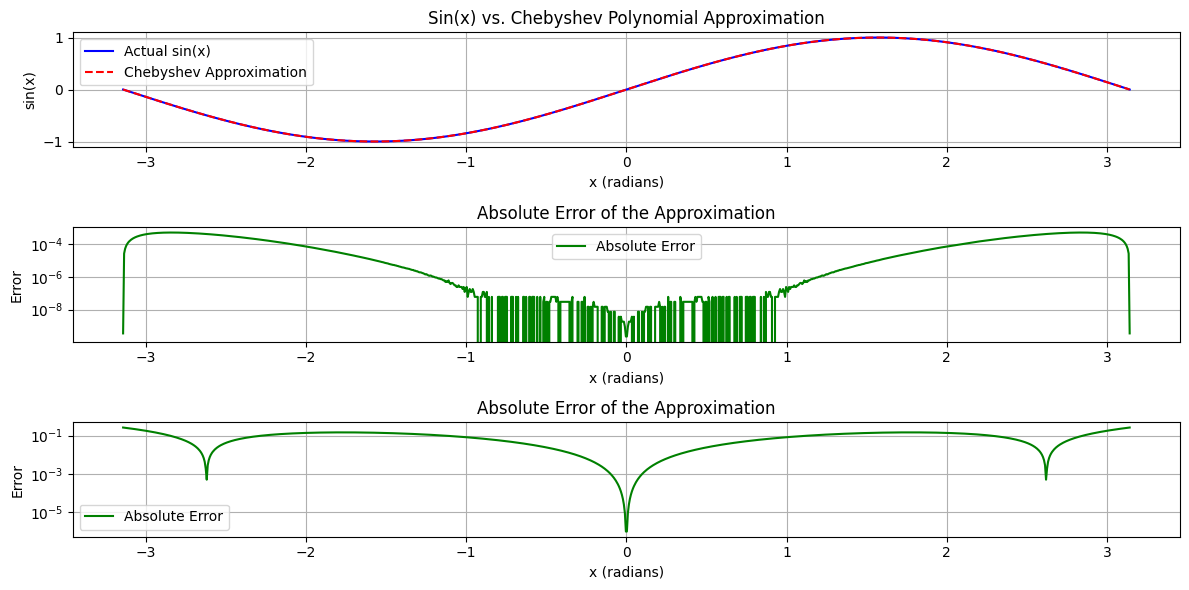

Maximum absolute error in the range [-π, π]: 4.82e-04


In [35]:
import numpy as np
import matplotlib.pyplot as plt

coeffs = [
        -0.101321183346709072589001712988183609230944236760490476,  # x
        0.00662087952180793343258682906697112938547424931632185616,  # x^3
        -0.000173505057912483501491115906801116298084629719204655552,  # x^5
        2.52229235749396866288379170129828403876289663605034418e-6,  # x^7
    ]
def sin_cheby(x):
    # Coefficients of the Chebyshev polynomial
    x2 = x * x  # x^2
    # Evaluate the polynomial
    p7 = coeffs[3]
    p5 = p7 * x2 + coeffs[2]
    p3 = p5 * x2 + coeffs[1]
    p1 = p3 * x2 + coeffs[0]
    fx = p1 * x
    
    dp7 = 7 * coeffs[3]
    dp5 = dp7 * x2 + 5 * coeffs[2]
    dp3 = dp5 * x2 + 3 * coeffs[1]
    dfx = dp3 * x2 + coeffs[0]
    
    # Approximate sin(x) using the Chebyshev polynomial
    sinx = (
        (x - 3.1415927410125732 + 0.00000008742277657347586) *
        (x + 3.1415927410125732 - 0.00000008742277657347586) *
        fx
    )
    
    diff_sinx = 2*x*fx - (3.1415927410125732 - 0.00000008742277657347586)**2*dfx
    return sinx, diff_sinx

def plot_approximation_error():
    """
    Plots the error between the actual sin(x) and its Chebyshev approximation.
    """
    # Define the range of x values (e.g., from -2π to 2π)
    
    x = np.linspace( -np.pi, np.pi, 1000, dtype=np.float32)

    # Calculate actual sin(x)
    actual_sin = np.sin(x)
    actual_cos = np.cos(x)
    # Calculate the approximated sin(x)
    approx_sin, approx_cos = sin_cheby(x)

    # Calculate the absolute error
    error = np.abs(actual_sin - approx_sin)
    error_cos = np.abs(actual_cos - approx_cos)
    # Plot the actual sin(x) and its approximation
    plt.figure(figsize=(12, 6))

    plt.subplot(3, 1, 1)
    plt.plot(x, actual_sin, label='Actual sin(x)', color='blue')
    plt.plot(x, approx_sin, label='Chebyshev Approximation', linestyle='--', color='red')
    plt.title('Sin(x) vs. Chebyshev Polynomial Approximation')
    plt.xlabel('x (radians)')
    plt.ylabel('sin(x)')
    plt.legend()
    plt.grid(True)

    # Plot the error
    plt.subplot(3, 1, 2)
    plt.plot(x, error, label='Absolute Error', color='green')
    plt.title('Absolute Error of the Approximation')
    plt.xlabel('x (radians)')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(x, error_cos, label='Absolute Error', color='green')
    plt.title('Absolute Error of the Approximation')
    plt.xlabel('x (radians)')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Optionally, print maximum error
    max_error = np.max(error)
    print(f"Maximum absolute error in the range [-π, π]: {max_error:.2e}")

if __name__ == "__main__":
    plot_approximation_error()

Analytical Gradient:
 [37.56969574 51.73032602 57.50297949 38.36925152 59.57823248 48.77345145
 46.68995238 29.9904619  45.68214365 20.55980654]

Numerical Gradient:
 [37.56969573 51.73032604 57.50297947 38.36925153 59.57823248 48.77345146
 46.68995235 29.99046192 45.68214363 20.55980656]

Proposed Gradient:
 [  4.26346039  43.04418063  22.52550511   3.60138678  13.13764507
   9.87622889  44.22236202  -6.072358     9.26630557 -25.27987418]

Difference between Analytical and Numerical Gradient:
 [9.30607769e-09 1.92883931e-08 2.54060879e-08 1.16430883e-08
 3.75743525e-09 1.20360255e-08 3.07607522e-08 1.96494838e-08
 2.05500044e-08 1.41263037e-08]

Difference between Proposed and Numerical Gradient:
 [33.30623534  8.68614541 34.97747436 34.76786475 46.44058741 38.89722257
  2.46759033 36.06281992 36.41583806 45.83968074]


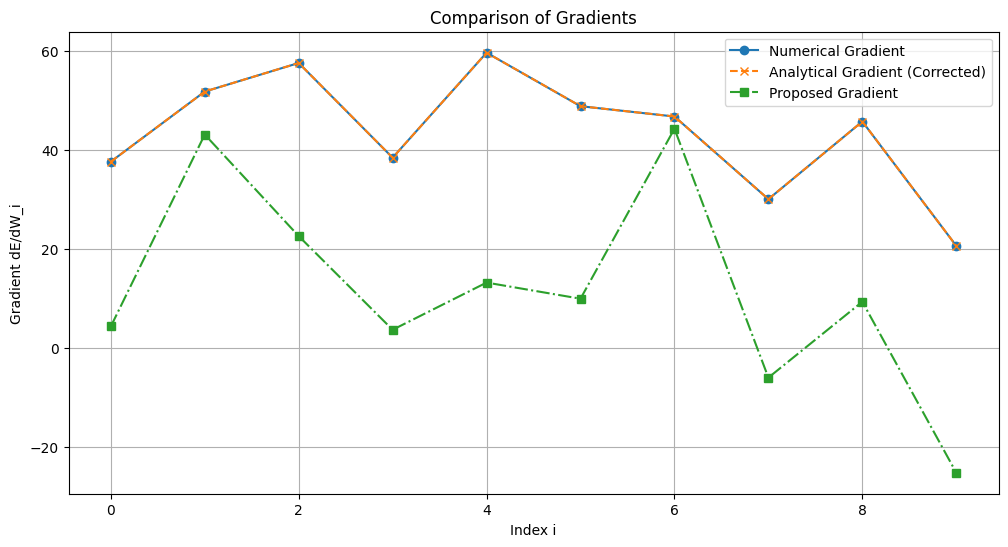

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

def compute_E(W, phi):
    """
    Compute the energy E = || S ||^2 where S = W * phi (circular convolution).
    """
    # Perform circular convolution via FFT
    S = ifft(fft(W) * fft(phi)).real
    E = np.sum(S**2)
    return E, S

def compute_analytical_gradient_corrected(W, phi):
    """
    Compute the analytical gradient dE/dW_i = 2 * sum_x S_x * phi_{x - i} with proper index alignment.
    """
    # Perform circular convolution to get S
    S = ifft(fft(W) * fft(phi)).real

    # Compute convolution of S with flipped phi
    phi_flipped = np.flip(phi)
    grad_E = 2 * ifft(fft(S) * fft(phi_flipped)).real

    # Shift the gradient by one index to align with numerical gradient
    grad_E_corrected = np.roll(grad_E, 1)

    # Since circular convolution, only the first len(W) elements are relevant
    grad_E_corrected = grad_E_corrected[:len(W)]

    return grad_E_corrected

def compute_numerical_gradient(W, phi, epsilon=1e-6):
    """
    Compute the numerical gradient using finite differences for circular convolution.
    """
    grad_E_numerical = np.zeros_like(W)
    for i in range(len(W)):
        W_eps_plus = W.copy()
        W_eps_minus = W.copy()
        W_eps_plus[i] += epsilon
        W_eps_minus[i] -= epsilon

        E_plus, _ = compute_E(W_eps_plus, phi)
        E_minus, _ = compute_E(W_eps_minus, phi)

        grad_E_numerical[i] = (E_plus - E_minus) / (2 * epsilon)
    return grad_E_numerical

def main():
    # Seed for reproducibility
    np.random.seed(0)

    # Define phi and W
    phi = np.random.randn(10)  # Example phi signal
    W = np.random.randn(10)    # Example convolution kernel

    # Compute gradients
    grad_E_analytical = compute_analytical_gradient_corrected(W, phi)
    grad_E_numerical = compute_numerical_gradient(W, phi)

    # Compute proposed gradient for comparison
    sum_phi_squared = np.sum(phi**2)
    grad_E_proposed = 2 * W * sum_phi_squared

    # Compare gradients
    print("Analytical Gradient:\n", grad_E_analytical)
    print("\nNumerical Gradient:\n", grad_E_numerical)
    print("\nProposed Gradient:\n", grad_E_proposed)

    # Compute the differences
    diff_analytical_numerical = np.abs(grad_E_analytical - grad_E_numerical)
    diff_proposed_numerical = np.abs(grad_E_proposed - grad_E_numerical)

    print("\nDifference between Analytical and Numerical Gradient:\n", diff_analytical_numerical)
    print("\nDifference between Proposed and Numerical Gradient:\n", diff_proposed_numerical)

    # Plot the gradients for visualization
    indices = np.arange(len(W))
    plt.figure(figsize=(12, 6))
    plt.plot(indices, grad_E_numerical, 'o-', label='Numerical Gradient')
    plt.plot(indices, grad_E_analytical, 'x--', label='Analytical Gradient (Corrected)')
    plt.plot(indices, grad_E_proposed, 's-.', label='Proposed Gradient')
    plt.xlabel('Index i')
    plt.ylabel('Gradient dE/dW_i')
    plt.title('Comparison of Gradients')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


